In [24]:
# load the diabetes dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr


In [10]:
df = pd.read_csv('diabetic_data.csv')
df.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [11]:
df.shape

(101766, 50)

In [13]:
# Basic missing value summary
df.replace("?", np.nan, inplace=True)

missing_summary = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_summary / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_summary,
    'Percent Missing': missing_percent
})

# Filter only columns with missing values
missing_df = missing_df[missing_df['Missing Values'] > 0]

missing_df

,Missing Values,Percent Missing
weight,98569,96.858479
max_glu_serum,96420,94.746772
A1Cresult,84748,83.277322
medical_specialty,49949,49.082208
payer_code,40256,39.557416
race,2273,2.233555
diag_3,1423,1.398306
diag_2,358,0.351787
diag_1,21,0.020636


In [25]:
# Drop 'weight' due to excessive missingness
df.drop(columns=['weight'], inplace=True)


KeyError: "['weight'] not found in axis"

In [16]:
# Impute 'medical_specialty' and 'race' with placeholder
df['medical_specialty'] = df['medical_specialty'].fillna('Unknown')
df['race'] = df['race'].fillna('Unknown')

In [17]:
df.drop(columns=['payer_code'], inplace=True)  
# Fill diagnosis codes with placeholder
for col in ['diag_1', 'diag_2', 'diag_3']:
    df[col] = df[col].fillna('Missing')

In [18]:
# 'max_glu_serum' and 'A1Cresult' — treat 'None' as a valid category (don’t impute)
# binary flags to indicate tests were taken because that can impact readmissioms
df['max_glu_serum_test_taken'] = (df['max_glu_serum'] != 'None').astype(int)
df['A1Cresult_test_taken'] = (df['A1Cresult'] != 'None').astype(int)

Understanding Target Variable (Readmission within 30 days)

readmitted
NO     53.911916
>30    34.928169
<30    11.159916
Name: proportion, dtype: float64


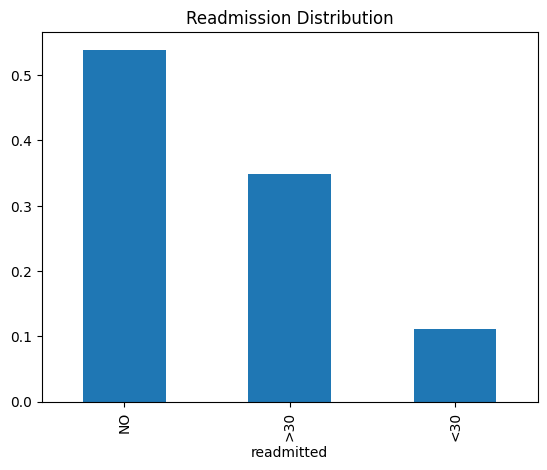

In [19]:
df['readmitted'].value_counts(normalize=True).plot(kind='bar', title="Readmission Distribution")
print(df['readmitted'].value_counts(normalize=True) * 100)



The dataset is unbalanced. Readmissions within 30 days is around ~11% of the total number of patients.

In [23]:
# Lets do binary classificatiion as most interested in 30 day readmission
df['readmit_30'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
print(df['readmit_30'].value_counts(normalize=True) * 100)

readmit_30
0    88.840084
1    11.159916
Name: proportion, dtype: float64


Analysis of numerical variables

In [26]:
from scipy.stats import pointbiserialr

numeric_cols = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]

for col in numeric_cols:
    corr, pval = pointbiserialr(df[col], df['readmit_30'])
    print(f"{col}: correlation = {corr:.3f}, p-value = {pval:.3e}")

time_in_hospital: correlation = 0.044, p-value = 3.455e-45
num_lab_procedures: correlation = 0.020, p-value = 8.208e-11
num_procedures: correlation = -0.012, p-value = 9.596e-05
num_medications: correlation = 0.038, p-value = 1.406e-34
number_outpatient: correlation = 0.019, p-value = 1.664e-09
number_emergency: correlation = 0.061, p-value = 8.295e-84
number_inpatient: correlation = 0.165, p-value = 0.000e+00
number_diagnoses: correlation = 0.050, p-value = 2.735e-56


Most corelation with number_inpatient, followed by number_emergency, number_diagnoses,time_in_hospital and num_medications

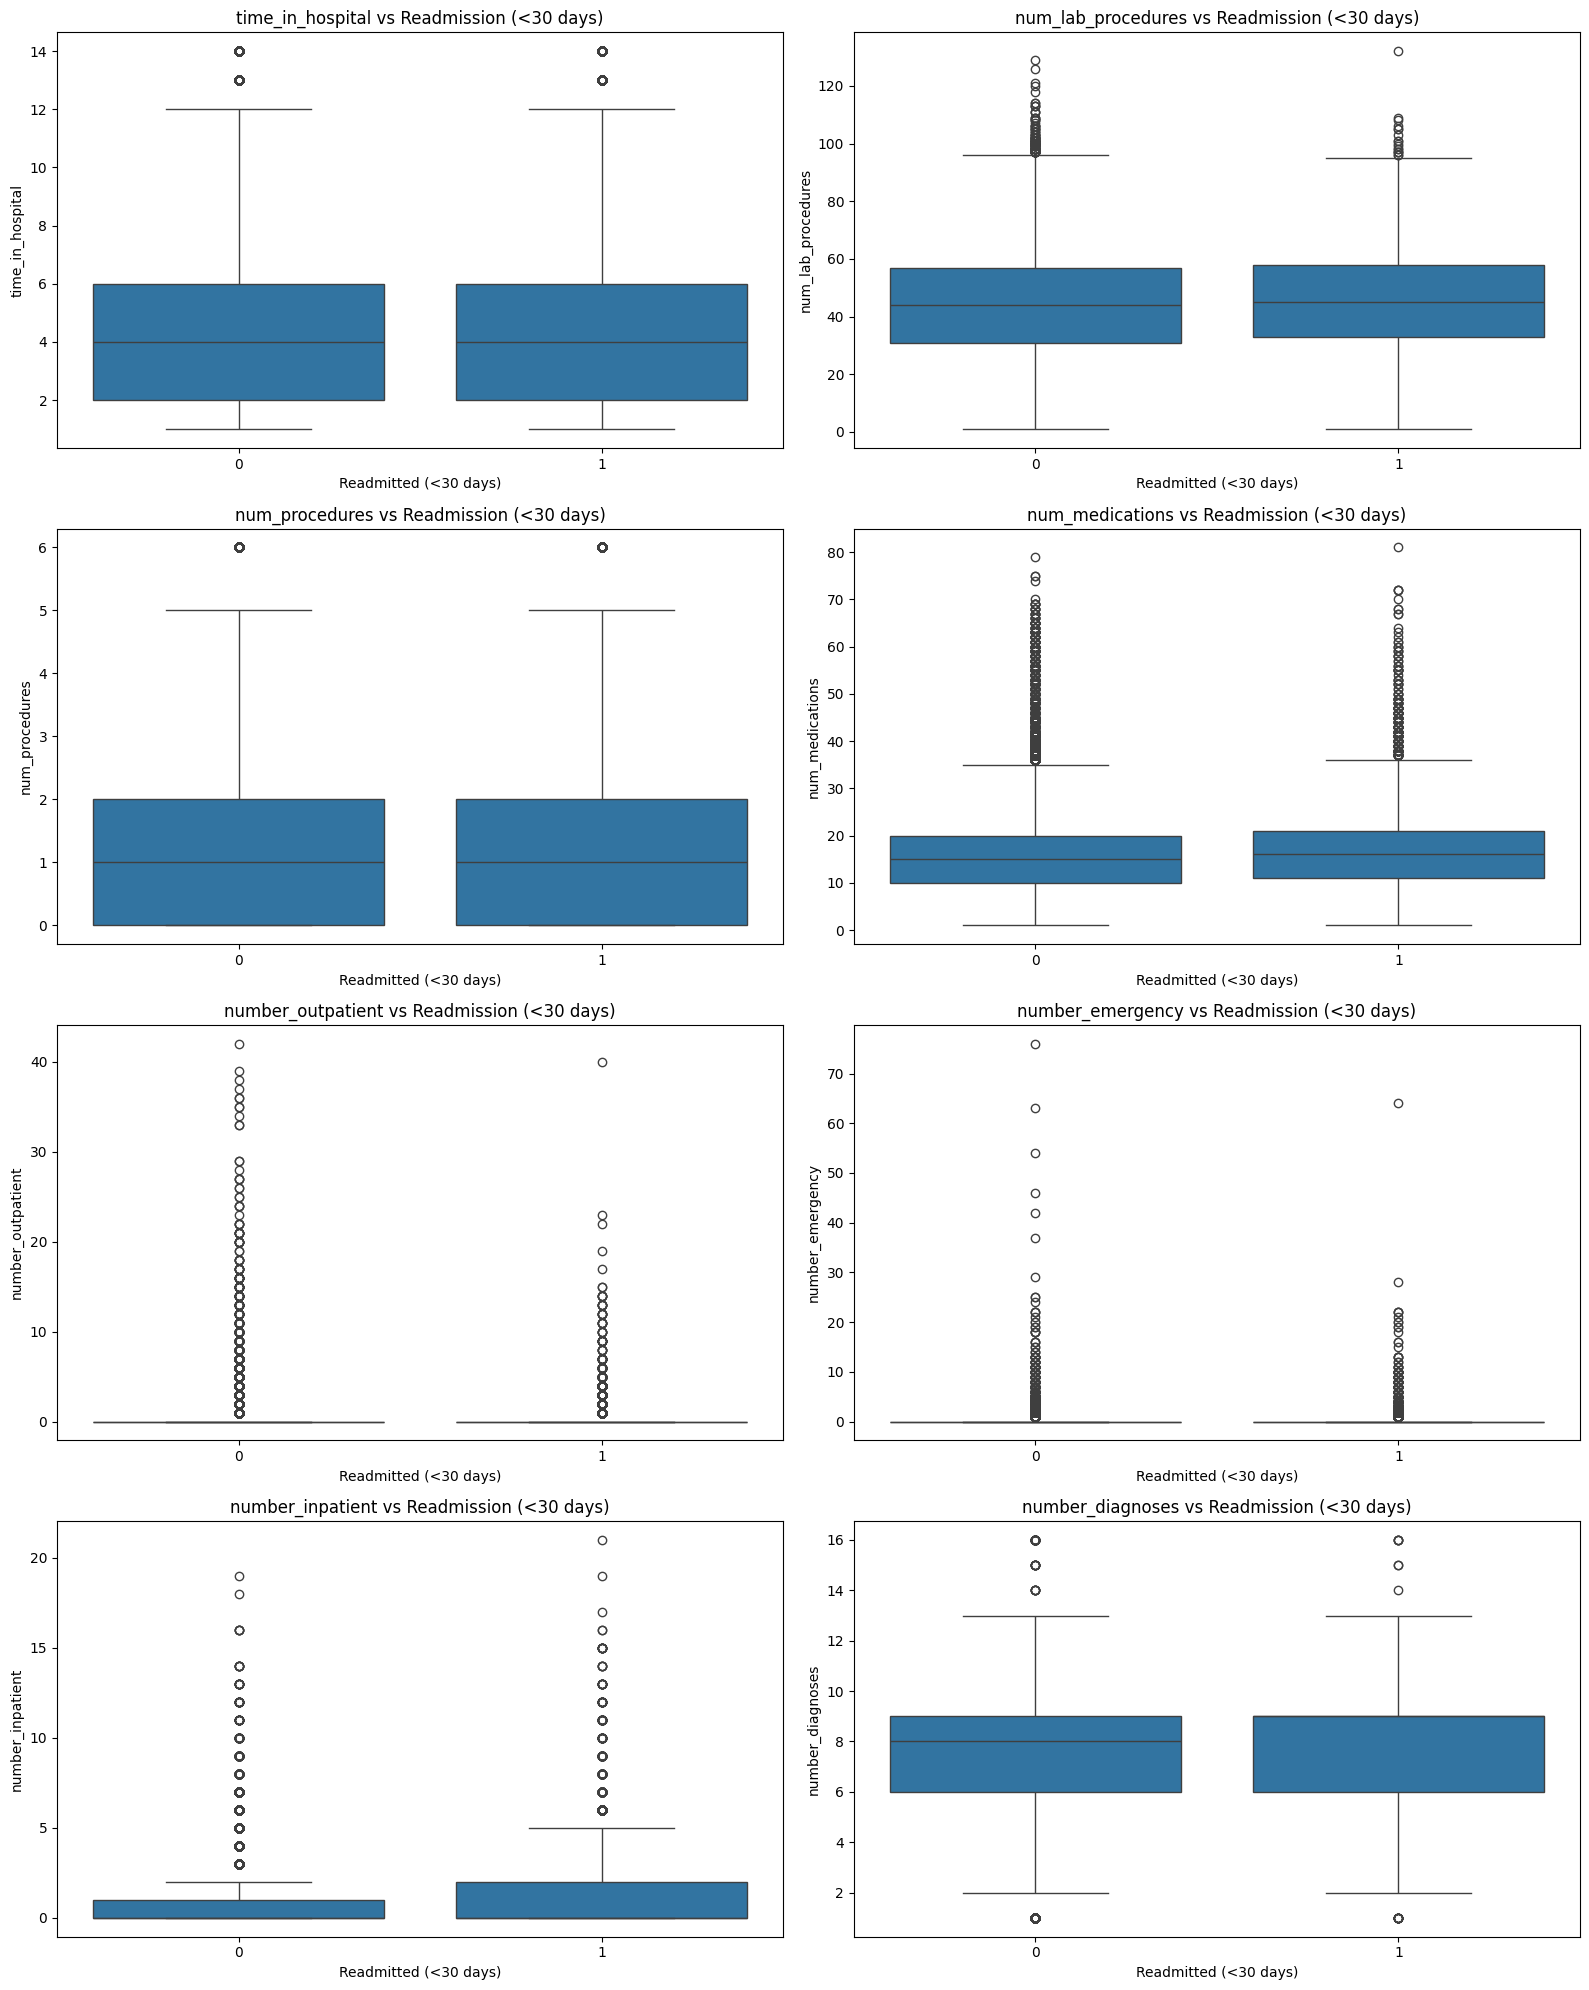

In [27]:
# look at distributions
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]

plt.figure(figsize=(16, 20))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x='readmit_30', y=col, data=df)
    plt.title(f'{col} vs Readmission (<30 days)')
    plt.xlabel("Readmitted (<30 days)")
    plt.ylabel(col)
plt.tight_layout()
plt.show()

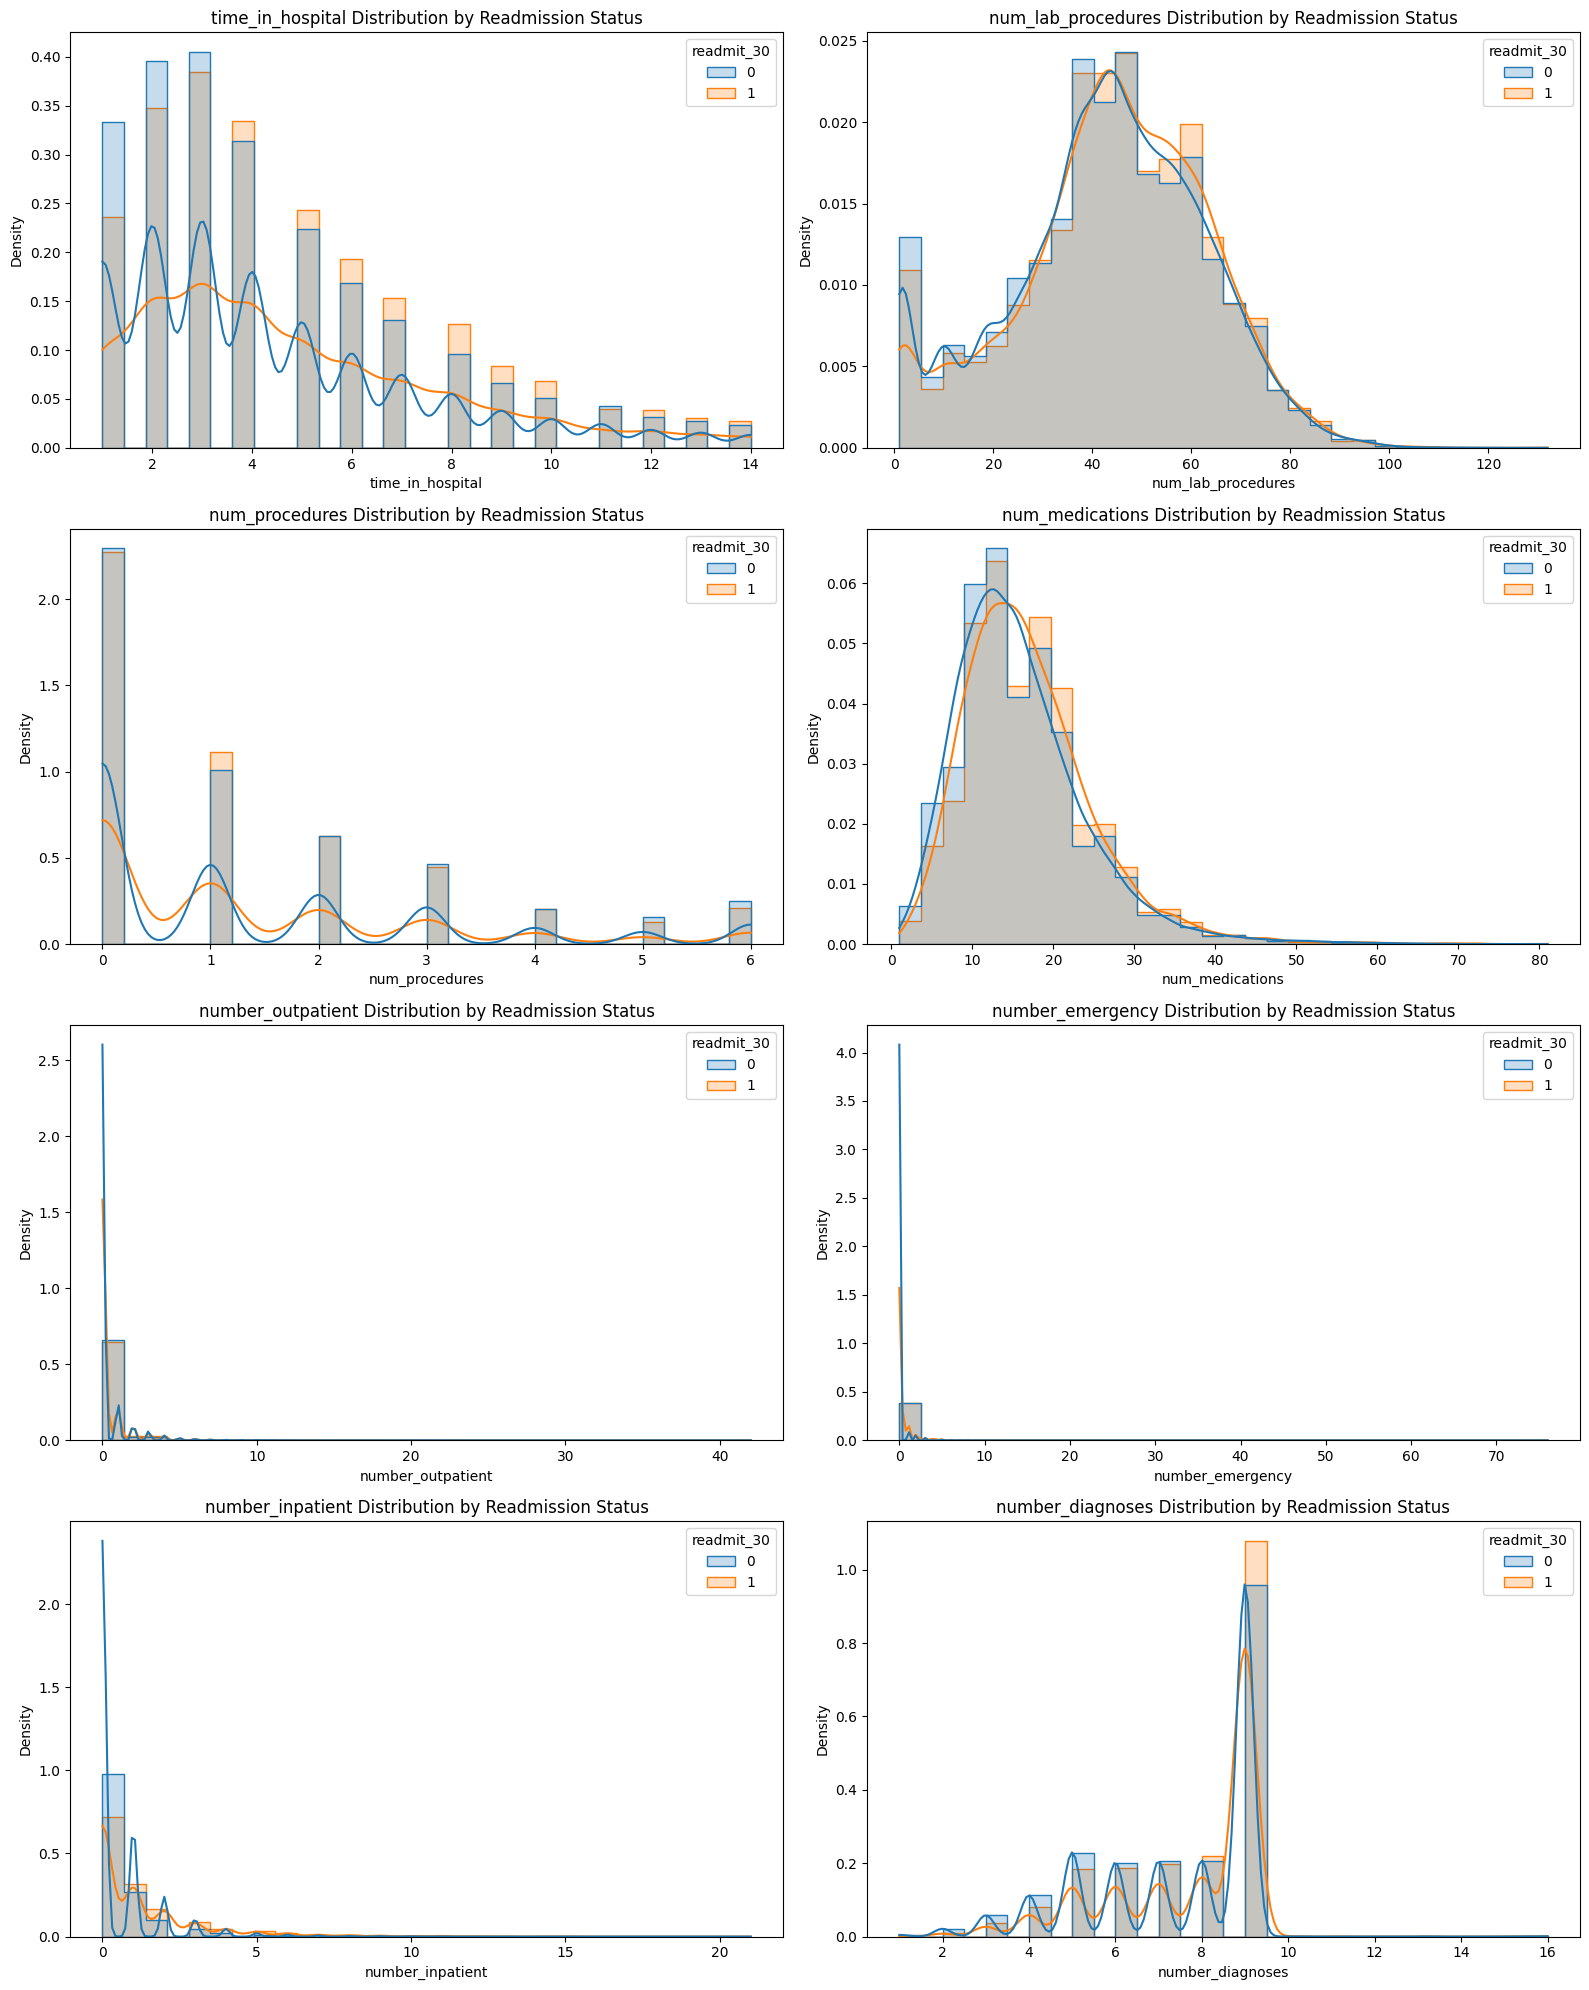

In [29]:
plt.figure(figsize=(16, 20))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(4, 2, i)
    sns.histplot(data=df, x=col, hue='readmit_30', kde=True, stat="density", 
                 common_norm=False, element="step", bins=30)
    plt.title(f'{col} Distribution by Readmission Status')
plt.tight_layout()
plt.show()

Understand categorical features

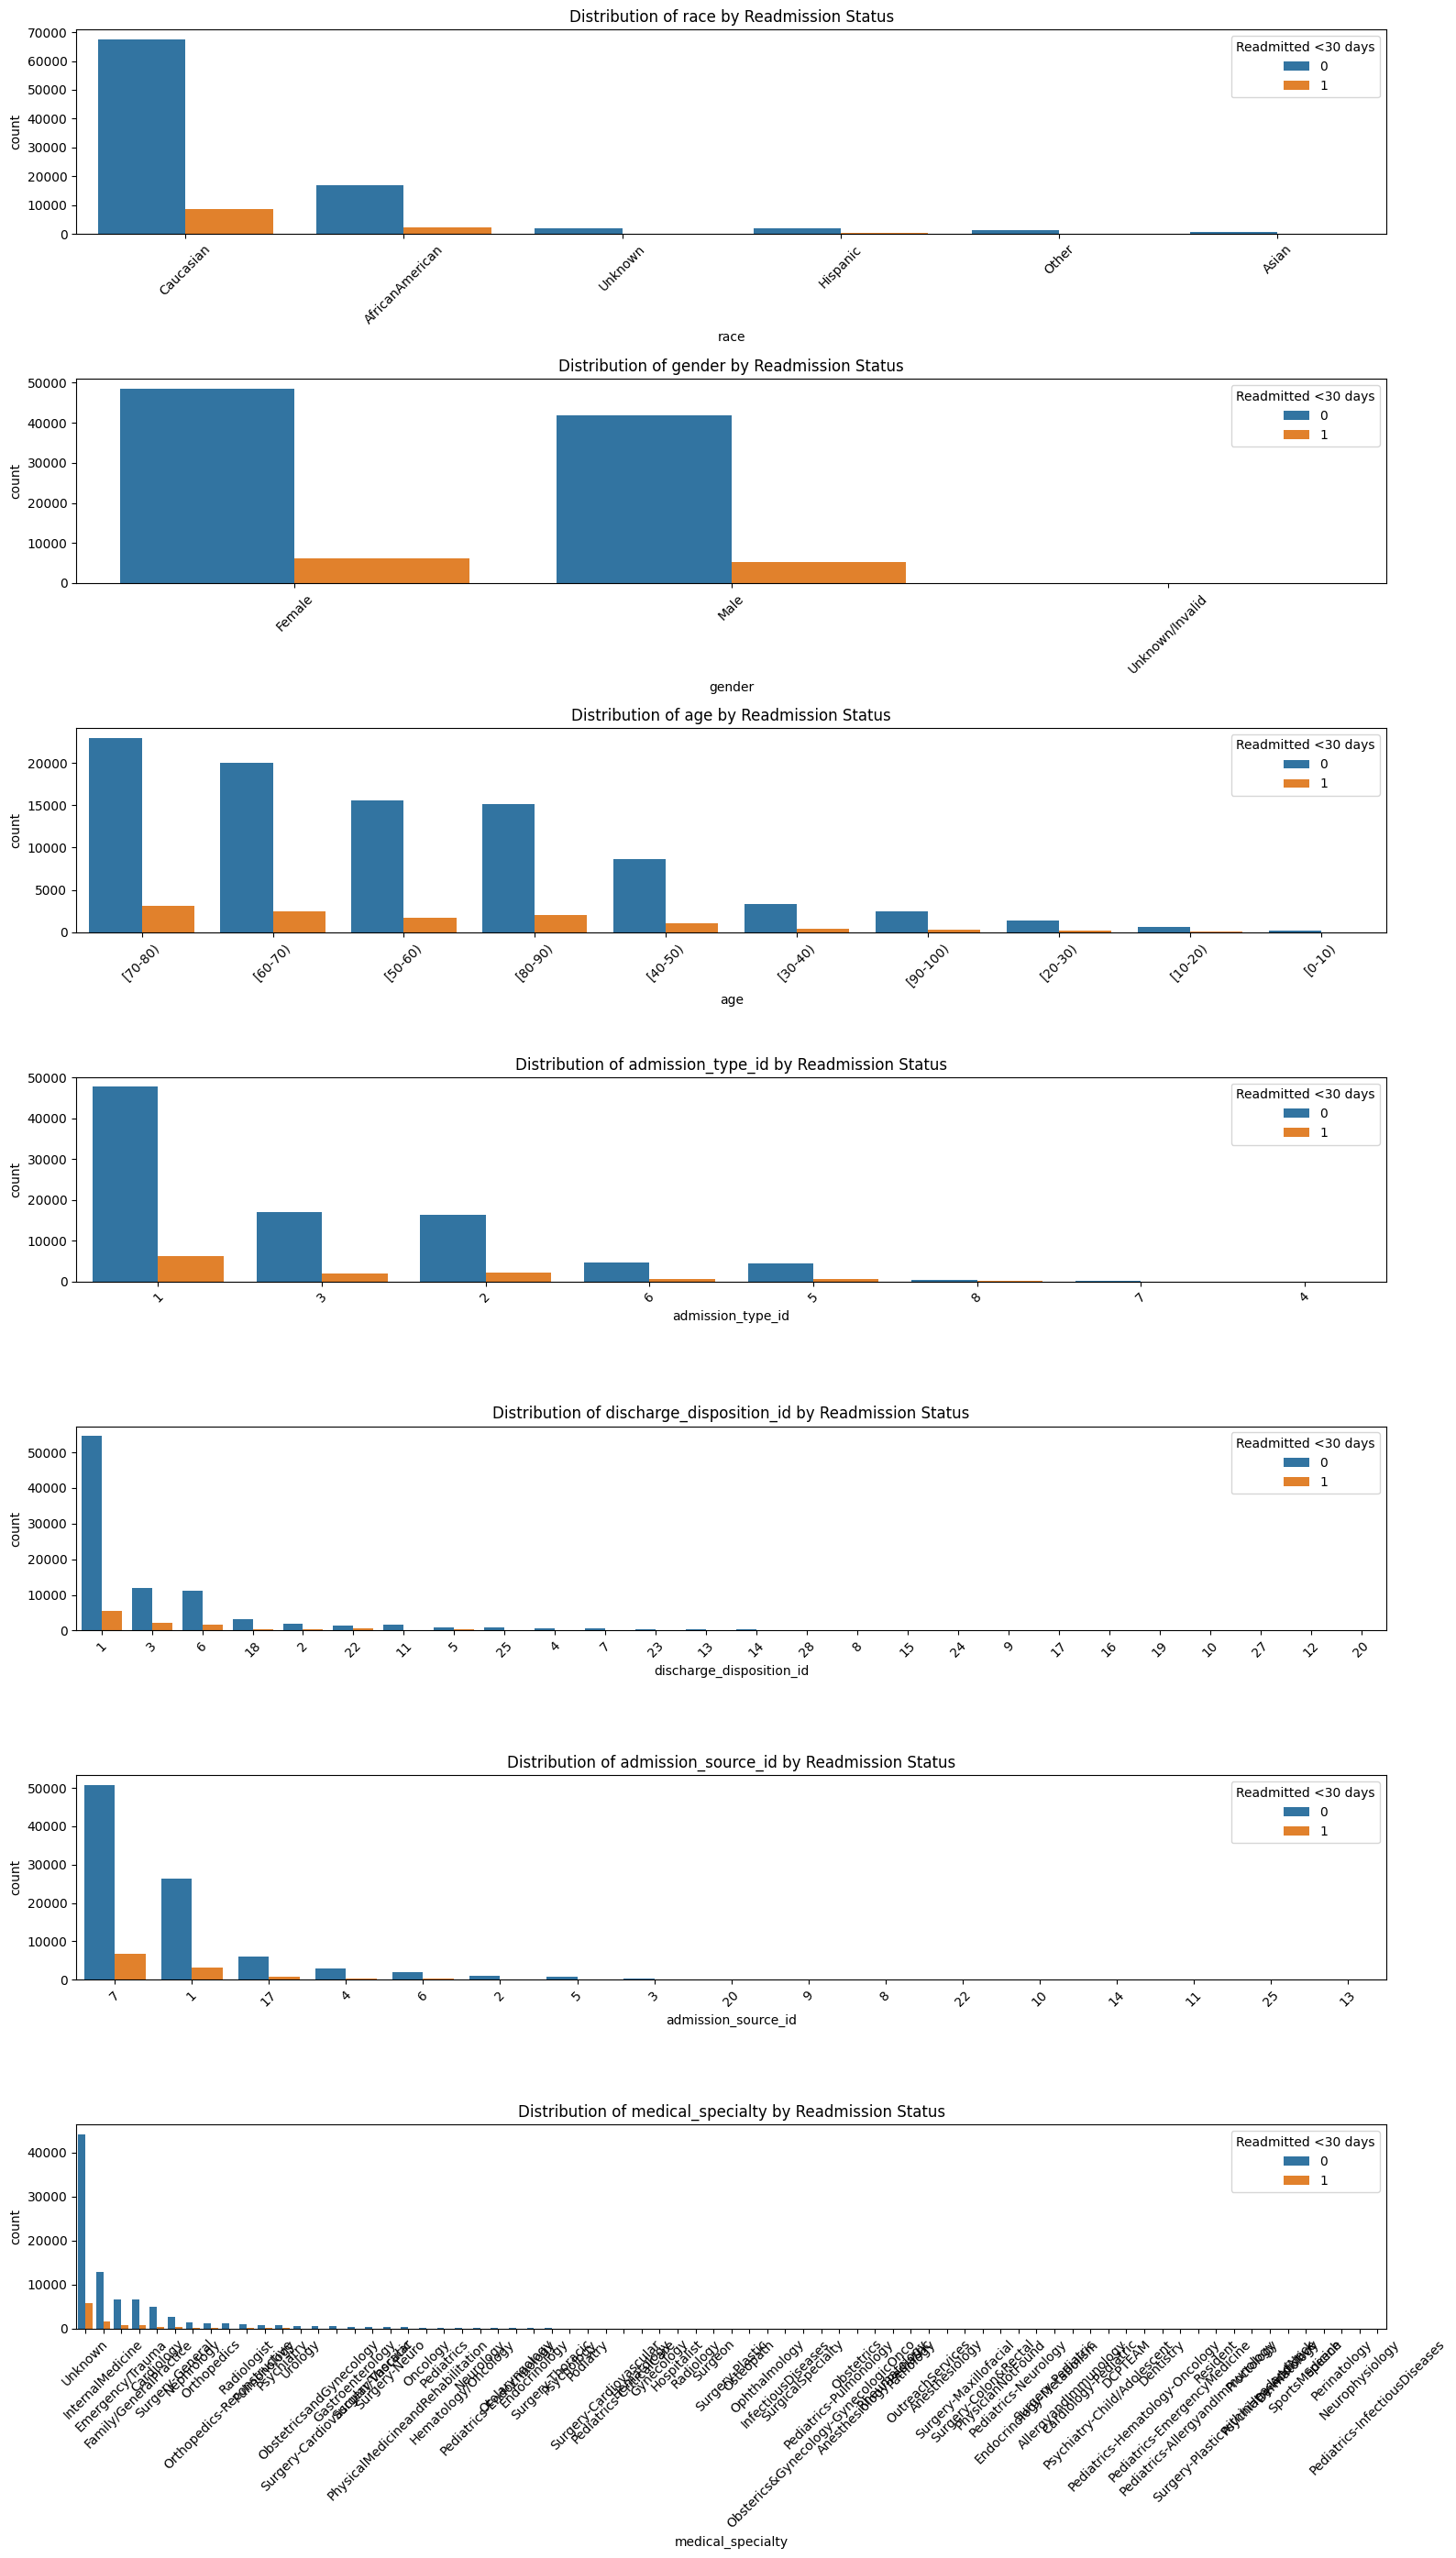

In [32]:
categorical_features = [
    'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 
    'admission_source_id', 'medical_specialty', 
]

plt.figure(figsize=(16, 4 * len(categorical_features)))

for i, col in enumerate(categorical_features, 1):
    plt.subplot(len(categorical_features), 1, i)
    sns.countplot(data=df, x=col, hue='readmit_30', order=df[col].value_counts().index)
    plt.title(f'Distribution of {col} by Readmission Status')
    plt.xticks(rotation=45)
    plt.legend(title='Readmitted <30 days')
plt.tight_layout()
plt.show()